# ArcGIS GeoAnalytics for Microsoft Fabric: Creating, reading, and writing spatial data

In this notebook, we will explore the fundamentals of working with spatial data in ArcGIS GeoAnalytics for Microsoft Fabric. We will showcase the process of reading data, creating new geometries, and writing spatial data. Upon completion of this guide, you will possess a solid comprehension of using [ArcGIS GeoAnalytics](https://developers.arcgis.com/geoanalytics-fabric/) for reading and writing data in [OneLake](https://learn.microsoft.com/en-us/fabric/onelake/onelake-overview) and in [ArcGIS feature services](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/feature-service/).  Let's begin!



***Public Preview notes*** 
* ArcGIS GeoAnalytics is enabled in the Fabric Runtime 1.3 only

* In the ArcGIS GeoAnalytics _Public Preview_, to render base map tiles when plotting maps using the [st.plot](https://developers.arcgis.com/geoanalytics-fabric/api-reference/geoanalytics_fabric.extensions.html#plot) functionality, you will need to  run the following configuration cell when starting your computing environment.  Note that using the configuration will lead to a slower startup for the computing environment.  This is not necessary if you do not require the base map tiles in your map.  Spatial data in your DataFrame will still render, however you will not have the base map tiles in the background.  

In [1]:
%%configure -f
{    
    "conf":    
    {   
        "spark.driver.extraJavaOptions" : "--add-opens java.base/jdk.internal.loader=ALL-UNNAMED",
        "spark.jars.packages": "com.google.protobuf:protobuf-java:3.25.5"    
    }
}

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, -1, Finished, Available, Finished)

## Add a Lakehouse
The Fabric Lakehouse is a location where you can store and manage your data.  To work with data within your Fabric environment, you will need to connect to a Lakehouse that houses the data.  

Your Lakehouse must be connected before you start your computing session.

To connect to a Lakehouse, click on `Lakehouses` in the Explorer pane and `Add Lakehouse`.

You can add an existing Lakehouse, or create a new one for this tutorial.  

In this example, we will use a new Lakehouse named `LearnLake`.

For more information, refer to ["What is a lakehouse in Microsoft Fabric?"](https://learn.microsoft.com/en-us/fabric/data-engineering/lakehouse-overview)

***When working with this notebook in Microsoft Fabric, if you do not attach a lakehouse, you will not be able to _write_ data using the examples in this notebook.***

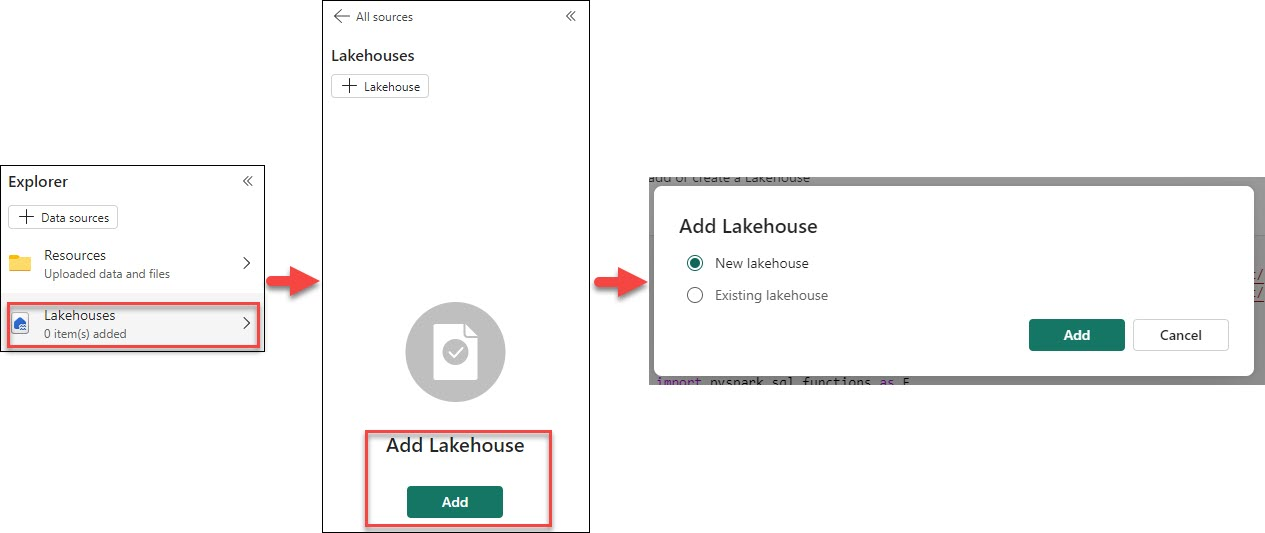

Once you have added or created your Lakehouse, we can connect to a computing session and read or write data from the connected Lakehouse.

Note that if you need to create or connect to a _different_ Lakehouse after you start your computing session, you will need to restart the computing session to connect the new Lakehouse.

## Import ArcGIS GeoAnalytics
To work with ArcGIS GeoAnalytics for Microsoft Fabric, you need to import it in your notebook.  The library is named `geoanalytics_fabric`

This imports the library at the top level.  To make the functionality easier to access, we recommend also importing the [geospatial functions](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/) directly, and to give them an easy to use alias for reference.  In the example below, we import the library and the functions with an alias of ```ST```.  Since each of the functions are named ST.\<function_name\> this makes them easy to reference and identifies them as being Spatial Type (ST) functions.  This will also align with the structure of examples throughout the ArcGIS GeoAnalytics documentation.


For instance, after importing, you would be able to reference the [ST_Buffer](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_buffer/) function using `ST.buffer` instead of `geoanalytics_fabric.sql.functions.buffer`.

See the [developer documentation](https://developers.arcgis.com/geoanalytics-fabric/) for more information about the functions available in ArcGIS GeoAnalytics.


In [3]:
# import ArcGIS GeoAnalytics
import geoanalytics_fabric
import geoanalytics_fabric.sql.functions as ST
import pyspark.sql.functions as F

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 4, Finished, Available, Finished)

## Ingest data 

For this sample, we will use a dataset of [New York City yellow cab pick-up / drop-off locations](https://learn.microsoft.com/en-us/azure/open-datasets/dataset-taxi-yellow) from the [Azure open datasets](https://azure.microsoft.com/en-us/products/open-datasets).  

This dataset is in a parquet format and contains latitude and longitude coordinates for both pick-up and drop-off locations for yellow cabs.  The dataset is quite large, so when we read in the data, we will limit to 1000 records collected starting in 2015 to simplify.

To read the data, we can use the code sample provided on the Azure open dataset page for working with PySpark in Azure Synapse.  Note that in the last line, we are using the PySpark [limit()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.limit.html) function to restrict the data to just 1000 records.

This may take a few minutes as we are reading and persisting the data to memory.


In [4]:
# https://learn.microsoft.com/en-us/azure/open-datasets/dataset-taxi-yellow
# Azure storage access info
blob_account_name = "azureopendatastorage"
blob_container_name = "nyctlc"
blob_relative_path = "yellow"
blob_sas_token = r""

# Allow SPARK to read from Blob remotely
wasbs_path = 'wasbs://%s@%s.blob.core.windows.net/%s' % (blob_container_name, blob_account_name, blob_relative_path)
spark.conf.set(
  'fs.azure.sas.%s.%s.blob.core.windows.net' % (blob_container_name, blob_account_name),
  blob_sas_token)
print('Remote blob path: ' + wasbs_path)

# SPARK read parquet
df = spark.read.parquet(wasbs_path).filter(F.col("puYear") > 2015).limit(1000)
df.persist().count()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 5, Finished, Available, Finished)

Remote blob path: wasbs://nyctlc@azureopendatastorage.blob.core.windows.net/yellow


1000

### Examine the data to see what is included
We can display the DataFrame that we read in to better understand what is in the data.  

In this case, we have some input that is geographic (latitude and longitude coordinates), but no actual geometry column.  If you use the PySpark [printSchema()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.printSchema.html) function, to look at the schema, you may notice there is no point geometry yet.


In [5]:
# print the schema for the table
df.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 6, Finished, Available, Finished)

root
 |-- vendorID: string (nullable = true)
 |-- tpepPickupDateTime: timestamp (nullable = true)
 |-- tpepDropoffDateTime: timestamp (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- tripDistance: double (nullable = true)
 |-- puLocationId: string (nullable = true)
 |-- doLocationId: string (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- rateCodeId: integer (nullable = true)
 |-- storeAndFwdFlag: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- fareAmount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mtaTax: double (nullable = true)
 |-- improvementSurcharge: string (nullable = true)
 |-- tipAmount: double (nullable = true)
 |-- tollsAmount: double (nullable = true)
 |-- totalAmount: double (nullable = true)
 |-- puYear: integer (nullable = true)
 |-- puMonth: integer (nullable = true)



In [6]:
# display the table
display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 7, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, aa4aa3b3-c2ef-4c87-ba60-865445ff2bcb)

### Clean up invalid latitude and longitude values

An important first step in working with spatial data is to look for incorrect or erroneous geometries. 

One way to do this is visually on a map, which you can see in the cell below, but you can also check for some common issues using Fabric's [Data Wrangler](https://learn.microsoft.com/en-us/fabric/data-science/data-wrangler) functionality.

The dataset in this notebook happens to have some incorrect / out-of-expected range values for the pick-up and drop-off latitude and longitude coordinates.  

In the map image below, we can see data around New York, but also in the ocean off of the coast of Africa.  These are data points erroneously listed with latitude and longitude values of 0. They are often described as being on [Null Island](https://en.wikipedia.org/wiki/Null_Island), a common "location" for data with missing values.   

 

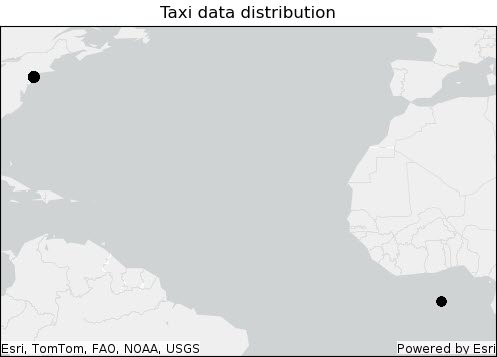

Besides visually exploring on a map, we can explore the distribution of values using [Fabric's Data Wrangler](https://learn.microsoft.com/en-us/fabric/data-science/data-wrangler) to check for anomalies and to automatically generate the code to clean out the erroneous values.  This allows us to better find the exact values in the dataset that are out of the expected range.

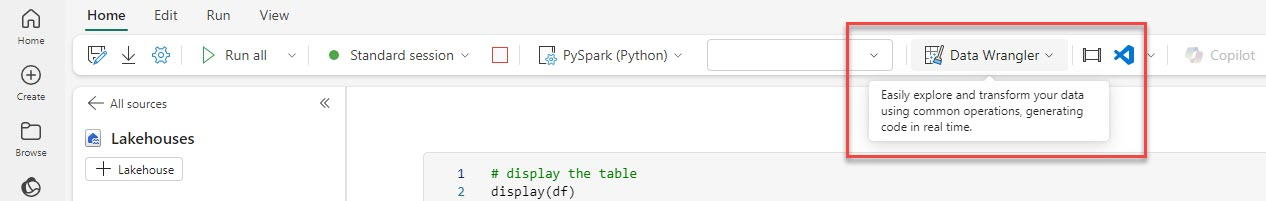

For this particular dataset, data wrangler shows that there are 0 values for both latitude and longitude. 

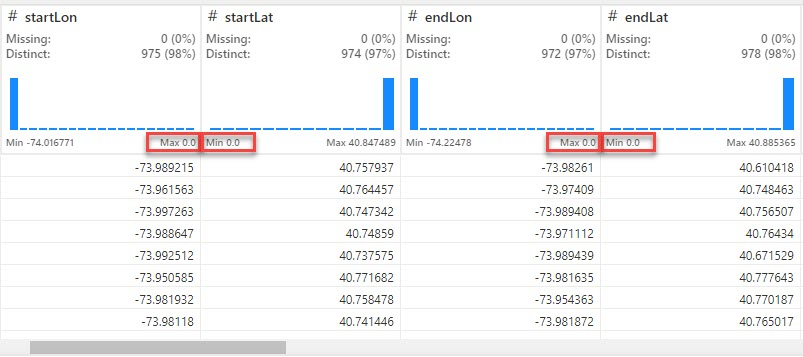

Using Data Wrangler we can add filters to eliminate the rows where the latitude or longitude are equal to 0.  The code to do this filtering can be added to our notebook directly from Data Wrangler using the `Add code to notebook` button.  This will translate the code in the Data Wrangler display (using Pandas) into PySpark to use in our notebook.

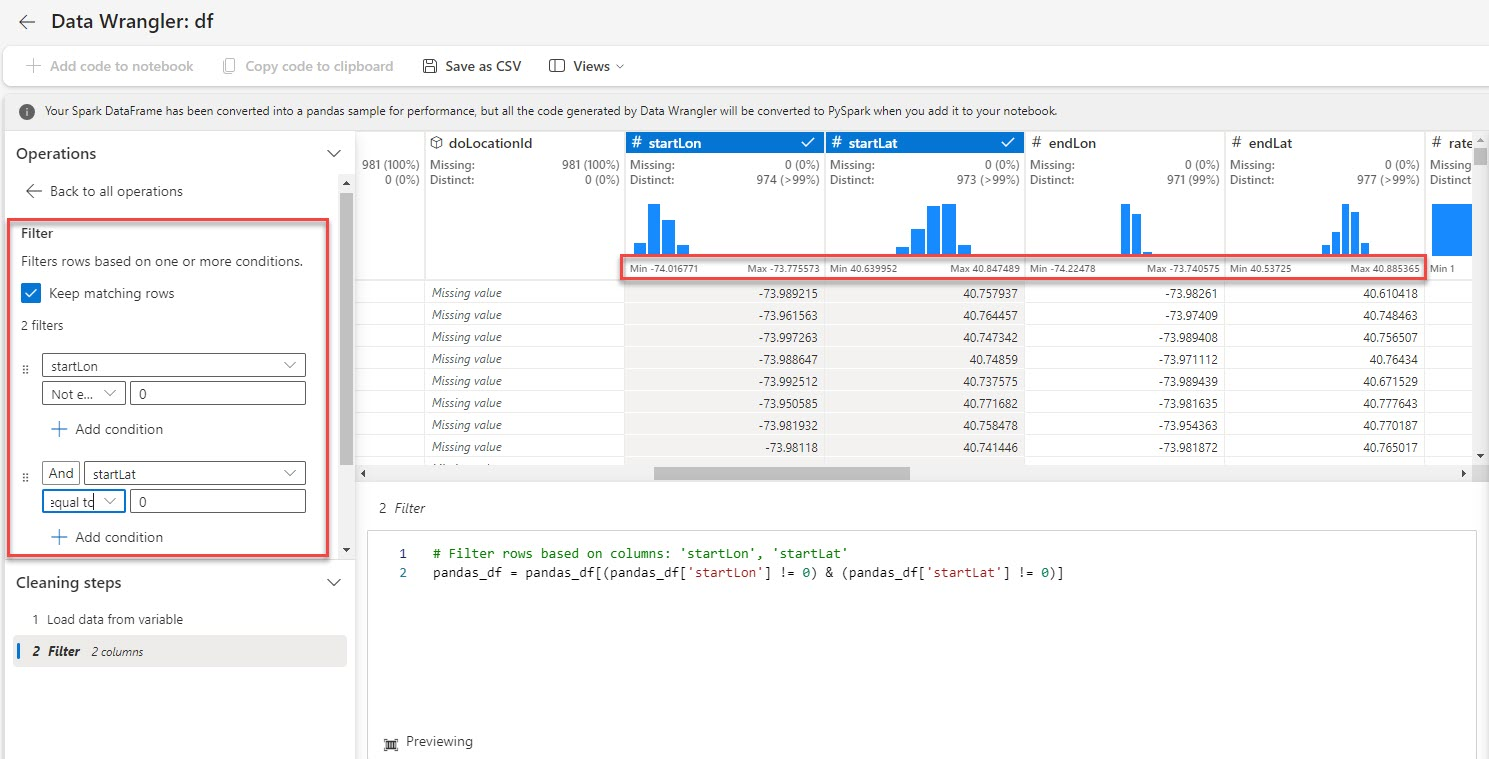

Here is the cell of data that Data Wrangler generated, using PySpark so that it can be run directly in this workflow.

In [7]:
# Code generated by Data Wrangler for PySpark DataFrame to filter out the erroneous values in the PySpark DataFrame

def clean_data(df):
    # Filter rows based on columns: 'startLon', 'startLat'
    df = df.filter((~df['startLon'].eqNullSafe(0)) & (~df['startLat'].eqNullSafe(0)))
    return df

df_clean = clean_data(df)
display(df_clean)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 8, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, c23ed34f-be72-4819-98e4-b149b4b70bd5)

## Create geometry from point coordinates

By default, this dataset that we imported doesn't have any geometry, but it does have latitude and longitude coordinates for the pick up and drop off locations for the yellow cabs.  To work with any data using ArcGIS GeoAnalytics, if there isn't already at least one geometry column, we will start by creating a geometry.  

Depending on the format of the data, there are a number of functions included with ArcGIS GeoAnalytics that can be used.  Since this dataset has point coordinates in two separate columns, we will use [ST_Point](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point/), but there are numerous functions for creating geometry such as:

* [ST_GeomFromBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_binary/)
* [ST_GeomFromEsriJSON](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_esri_json/)
* [ST_GeomFromGeoJSON](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_geojson/)
* [ST_GeomFromShape](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_shape/)
* [ST_GeomFromText](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_text/)
* [ST_Linestring](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_linestring/)
* [ST_Point](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point/)
* [ST_Polygon](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_polygon/)



[ST_Point](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point/) takes two numeric columns or double values as input and returns a point column. The two numeric columns or values must contain the x,y coordinates of the point geometries. You can optionally specify a spatial reference for the result point column.  In the example below, we add the spatial reference identifier of 4326.  This indicates that the coordinates use the [World Geodetic System 1984 coordinate system](https://en.wikipedia.org/wiki/World_Geodetic_System), or WGS84.

You can find more information about coordinate systems and spatial reference identifiers in the ArcGIS GeoAnalytics core concepts on [Coordinate systems and transformations](https://developers.arcgis.com/geoanalytics-fabric/core-concepts/coordinate-systems/).

Note that the ordering of the coordinates used as input for [ST_Point](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point/) is (longitude, latitude) or (x,y).


In [8]:
# create a new column called geom_start to represent the starting location for each yellow cab trip
# when we create the point geometry here, we are adding an optional value for the spatial reference. In this case it is 4326 (the World Geodetic Survey of 1984, or WGS84)
df_clean = df_clean.withColumn("geom_start", ST.point("startLon", "startLat", 4326))

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 9, Finished, Available, Finished)

In [9]:
# print the schema to confirm the creation of a point geometry named geom_start
df_clean.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 10, Finished, Available, Finished)

root
 |-- vendorID: string (nullable = true)
 |-- tpepPickupDateTime: timestamp (nullable = true)
 |-- tpepDropoffDateTime: timestamp (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- tripDistance: double (nullable = true)
 |-- puLocationId: string (nullable = true)
 |-- doLocationId: string (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- rateCodeId: integer (nullable = true)
 |-- storeAndFwdFlag: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- fareAmount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mtaTax: double (nullable = true)
 |-- improvementSurcharge: string (nullable = true)
 |-- tipAmount: double (nullable = true)
 |-- tollsAmount: double (nullable = true)
 |-- totalAmount: double (nullable = true)
 |-- puYear: integer (nullable = true)
 |-- puMonth: integer (nullable = true)
 |-- 

When displaying tables with a geometry, the point, line, or polygon geometry is automatically converted into a more human-readable format for display.  

Take a look at the geometry as listed in new ```geom_start``` column.

In [10]:
# display just the geom_start column of data
display(df_clean.select("geom_start"))

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 11, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 98d77938-6619-4b5b-a0b1-5b5a0e9a3576)

Now that there is a geometry, we can plot the data with the built in plotting functionality with [`st.plot`](https://developers.arcgis.com/geoanalytics-fabric/api-reference/geoanalytics_fabric.extensions.html#plot).

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 12, Finished, Available, Finished)

<Axes: >

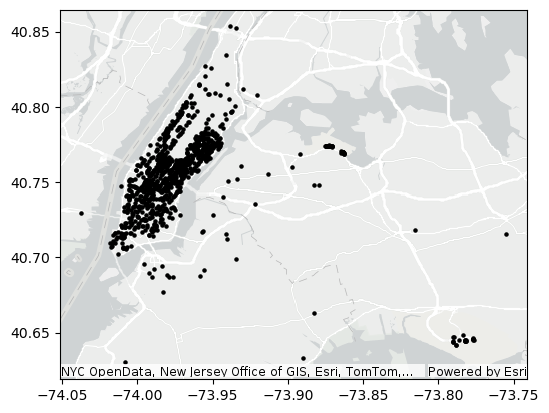

In [11]:
df_clean\
    .st.plot(basemap="light", marker_size=5, color="black", geometry="geom_start")

## Write spatial data to files in the Lakehouse

ArcGIS GeoAnalytics library can write data in numerous formats.  Common spatial formats include:

* [ArcGIS Feature service](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/feature-service/)
* [GeoJSON](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geojson/)
* [GeoParquet](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geoparquet/)
* [Shapefile](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/shapefile/)

Other common formats for writing data include [Delta](https://docs.delta.io/latest/delta-intro.html), [Apache Parquet](https://parquet.apache.org/), and [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) formats.  While these formats aren't inherently spatial, they are often used to store spatial data with the geometries as [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON), [well-known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry), [well-known binary](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry#Well-known_binary), or other non-spatial representations of the geometry.  To write to these formats, you will need to convert any geometry in your DataFrame to a different format.



***If you have not attached a lakehouse to this notebook you will not be able to write spatial data using the examples below***

### Converting geometry to text or binary formats
ArcGIS GeoAnalytics includes a set of functions for converting between geometry representations.  

The cell below, shows the result of converting our ```geom_start``` point geometry column into several common formats: [GeoJSON](https://en.wikipedia.org/wiki/GeoJSON), [well-known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry), [well-known binary](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry#Well-known_binary), and as columns with the individual coordinates.

These rely on the ArcGIS GeoAnalytics functions:

* [ST_AsGeoJSON](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_geojson/)
* [ST_AsText](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_text/)
* [ST_AsBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_binary/)
* [ST_X](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_x/)
* [ST_Y](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_y/)


In [12]:
# Examples of converting a geometry type to other formats
# Convert to GeoJSON, well-known text, well-known binary, and creating separate columns for the x & y coordinates
display(
    df_clean.select("geom_start",
        ST.as_geojson("geom_start").alias("Geom as GeoJSON"),
        ST.as_text("geom_start").alias("Geom as Text"),
        ST.as_binary("geom_start").alias("Geom as Binary"),
        ST.x("geom_start").alias("Geom X coordinate"),
        ST.y("geom_start").alias("Geom Y coordinate")
    )
)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 13, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 8fefab53-8f15-4249-93c0-8d9bdcd1d37e)

To better understand the new formats, we can use the PySpark [printSchema()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.printSchema.html) function to see the data type for each of the columns.

In [13]:
# use printSchema() to see the data type for each format
df_clean.select("geom_start",
    ST.as_geojson("geom_start").alias("Geom as GeoJSON"),
    ST.as_text("geom_start").alias("Geom as Text"),
    ST.as_binary("geom_start").alias("Geom as Binary"),
    ST.x("geom_start").alias("Geom X coordinate"),
    ST.y("geom_start").alias("Geom Y coordinate")
).printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 14, Finished, Available, Finished)

root
 |-- geom_start: point (nullable = true)
 |-- Geom as GeoJSON: string (nullable = true)
 |-- Geom as Text: string (nullable = true)
 |-- Geom as Binary: binary (nullable = true)
 |-- Geom X coordinate: double (nullable = true)
 |-- Geom Y coordinate: double (nullable = true)



### Common non-spatial formats
We will start with two common non-spatial formats for writing data: [Delta](https://docs.delta.io/latest/delta-intro.html) and [CSV](https://en.wikipedia.org/wiki/Comma-separated_values).

Neither of these formats support spatial data directly, so you will need to convert the geometry fields in your dataset prior to writing them into your Lakehouse.   

#### Writing Delta
In Microsoft Fabric, the [Delta Lake table format](https://docs.delta.io/latest/delta-intro.html) is the standard for analytics.  However, it does not recognize geometry formats directly.  

For writing Delta, the recommendation is to convert your geometry from the GeoAnalytics geometry type into [well-known binary](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry#Well-known_binary). This is a good format for making the geometry easily available in a compact format.

To do this, you can use the [ST_AsBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_binary/) function when writing the table.  This is demonstrated in the cell below.

In [14]:
# Write a delta file with well-known binary geometry
df_clean\
    .withColumn("geom_start", ST.as_binary("geom_start"))\
    .write\
    .mode("overwrite")\
    .format("delta")\
    .save("Tables/taxi_delta")


StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 15, Finished, Available, Finished)

#### Writing CSV
As noted above, not all output file types can support geometry.  

For instance, if we wanted to write our table to a CSV, the ```geom_start``` point geometry column would lead to an error: ```AnalysisException: Column `geom_start` has a data type of point, which is not supported by CSV.```

We also cannot just convert the column to binary, as that format is also not supported and we would see: ```AnalysisException: Column `geom_start` has a data type of binary, which is not supported by CSV.```

However, we can convert the geometry to a well-known text format using [ST_AsText](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_as_text/) and write the geometry in that format to a table.

In [15]:
df_clean\
    .withColumn("geom_start", ST.as_text("geom_start"))\
    .write\
    .mode("overwrite")\
    .format("csv")\
    .option("header", True)\
    .save("Tables/taxi_csv_wkt.csv")

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 16, Finished, Available, Finished)

### ArcGIS GeoAnalytics supported spatial file formats
ArcGIS GeoAnalytics supports writing to several spatial formats directly.  You can save these files in your Lakehouse or other connected environment.

In this section we will look at the following formats supported by ArcGIS GeoAnalytics:


* [GeoJSON](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geojson/)
* [GeoParquet](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geoparquet/)
* [Shapefile](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/shapefile/)
* [ArcGIS Feature service](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/feature-service/)


#### Writing GeoJSON

[GeoJSON](https://en.wikipedia.org/wiki/GeoJSON) is an open standard geospatial data interchange format that represents simple geographic features and their nonspatial attributes. Based on JavaScript Object Notation (JSON), GeoJSON is a format for encoding a variety of geographic data structures. It uses a geographic coordinate reference system, World Geodetic System 1984, and units of decimal degrees. To learn more about GeoJSON, see the [GeoJSON specification](https://www.rfc-editor.org/rfc/rfc7946).

GeoJSON format files can be written directly using the ["geojson" format option](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geojson/) as implemented in ArcGIS GeoAnalytics. 

In [16]:
df_clean\
    .write\
    .mode("overwrite")\
    .format("geojson")\
    .save("Tables/taxi_geojson")

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 17, Finished, Available, Finished)

#### Writing GeoParquet
[GeoParquet](https://geoparquet.org/) is a standardized open-source columnar storage format that extends [Apache Parquet](https://parquet.apache.org/) by defining how geospatial data should be stored, including the representation of geometries and the required additional metadata. Parquet is highly structured meaning it stores the schema and data type of each column with the data files. GeoParquet's structure enables interoperability between any system that reads or writes spatial data in Parquet format.

GeoParquet files can be written directly using the 
["geoparquet" format option](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geoparquet/) as implemented in ArcGIS GeoAnalytics.

In [17]:
df_clean\
    .write\
    .mode("overwrite")\
    .format("geoparquet")\
    .save("Tables/taxi_geoparquet")

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 18, Finished, Available, Finished)

#### Writing Shapefiles
[Shapefile](https://en.wikipedia.org/wiki/Shapefile) is an Esri vector data storage format commonly used in geospatial analysis and GIS software applications. For more information on shapefiles, see the [Shapefile format specification](http://www.esri.com/library/whitepapers/pdfs/shapefile.pdf).

Shapefiles consist of 3 or more files (at minimum these will be *.shp, *.dbf, and *.shx) and will be written into a folder containing all of the relevant parts.

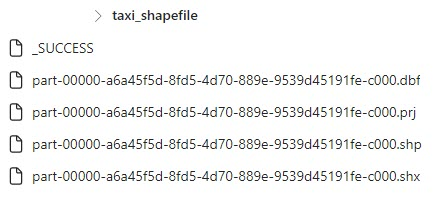

Shapefiles can be written directly using the ["shapefile" format option](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/shapefile/) as implemented in ArcGIS GeoAnalytics.

In the example below we are using the option ```coalesce(1)``` when we create the shapefile. The PySpark [coalesce](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.functions.coalesce.html) function controls the number of partitions in the result. A coalesce value enables the number of partitions to be reduced, resulting in fewer output shapefiles. For example, ```.coalesce(1)``` will write the data to one shapefile.  Otherwise, by default, a shapefile will be written for each partition.



In [18]:
# write shapefile
df_clean\
    .coalesce(1)\
    .write\
    .format("shapefile")\
    .mode("overwrite")\
    .save("Tables/taxi_shapefile")

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 19, Finished, Available, Finished)

#### Writing to Feature Services

A feature service is a data service that stores and hosts spatial and nonspatial data online. In a feature service, spatial datasets are feature layers and non-spatial datasets are tables. You can query, edit and analyze data in a feature service.  Feature service URLs are typically in the formats shown below.

URL for a feature service layer or table hosted in ArcGIS Online: ```https://<host>/<uniqueID>/ArcGIS/rest/services/<serviceName>/FeatureServer/<Layer or Table ID>```

URL for a feature service layer or table hosted in ArcGIS Enterprise: ```https://<host>/<webadaptor>/rest/services/Hosted/<serviceName>/FeatureServer/<Layer or Table ID>```

Refer to the feature service documentation for [ArcGIS Online](https://doc.arcgis.com/en/arcgis-online/manage-data/hosted-web-layers.htm) and [ArcGIS Enterprise](https://enterprise.arcgis.com/en/server/latest/publish-services/windows/what-is-a-feature-service-.htm) for more details.

##### Register a GIS
Authentication is required when reading or saving a secured feature service hosted by ArcGIS Online or ArcGIS Enterprise. ArcGIS GeoAnalytics supports authentication by registering a GIS (i.e. a connection to ArcGIS Online or ArcGIS Enterprise) with the ```register_gis``` function.

The default GIS in ```register_gis``` is ArcGIS Online. The following example shows registering ArcGIS Online as a GIS with a username and password for a built-in account.  

The example is commented out as it requires valid ArcGIS Online credentials to run successfully.  If you would like to test writing to feature services, you will need to provide your own credentials prior to un-commenting the code to test the functionality.



If you are working with ArcGIS Enterprise, have a PKI protected environment, or use OAuth as your authentication method, additional details can be found in the [ArcGIS GeoAnalytics documentation](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/feature-service/).

In [19]:
# register a GIS to save feature services

# The default GIS is ArcGIS Online
# The credentials below are not valid in ArcGIS Online, this code is for demonstration only
# If you have valid credentials, you can uncomment the line below and provide your credential information
# It is recommended to secure your credentials using the Azure Key Vault instead of hard-coding them directly into any notebooks in Microsoft Fabric.
# https://learn.microsoft.com/en-us/azure/key-vault/general/overview

# geoanalytics_fabric.register_gis("myGIS", username="User", password="p@ssw0rd")

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 20, Finished, Available, Finished)

Once a GIS has been registered, you can write your data to a feature service.  

Feature services can be written using the ["feature-service" format option](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/feature-service/) as implemented in ArcGIS GeoAnalytics.



In [20]:
# example code for writing to a feature service
# this will not write unless you connect to and register a valid GIS in the cell above

# df_clean\
#     .write\
#     .format("feature-service")\
#     .option("gis", "myGIS")\
#     .option("serviceName", "myServiceName")\
#     .option("layerName", "myLayer")\
#     .save()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 21, Finished, Available, Finished)

## Read spatial data

In this section, we will explore methods for reading _spatial_ data using ArcGIS GeoAnalytics.  

In some instances, the data may come from a data source that doesn't contain a geometry, and the spatial data will need to be converted into a geometry type.  For instance, in the examples below we will do that with:
* a Delta format table that has geometry stored in a [well-known binary](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry#Well-known_binary) (WKB) format
* a CSV with geometry stored in a [well-known text](https://en.wikipedia.org/wiki/Well-known_text_representation_of_geometry) (WKT) format

We will also look at reading explicitly spatial formats, where the geometry is read directly when the file is ingested.  These formats include:

* [GeoJSON](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geojson/)
* [GeoParquet](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geoparquet/)
* [Shapefile](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/shapefile/)
* [ArcGIS Feature service](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/feature-service/)



### Read from Delta
In Fabric you can easily read data from a Delta file from your Lakehouse through the fly-out menu next to your delta table in the Lakehouse, or by dragging and dropping the file into an empty cell in your notebook.  When you do this Fabric will auto-generate a basic set of code to read in the data.

The auto-generated code in Fabric doesn't create any geometry for you, so you may need to create that geometry separately.  You can use the functions in ArcGIS GeoAnalytics to do these conversions as part of the import process.

For instance, 
```
df = spark.sql("SELECT * FROM LearnLake.taxi_delta LIMIT 1000")\
    .withColumn("geom_start", ST.geom_from_binary("geom_start"))
```

If you are using a Lakehouse with a different name, the auto-generated code will reference your Lakehouse using that name and not `LearnLake` as is shown in the example above.  When using the Fabric capabilities to auto-generate code to read Delta files from a Lakehouse, it will automatically use the name for your connected Lakehouse.


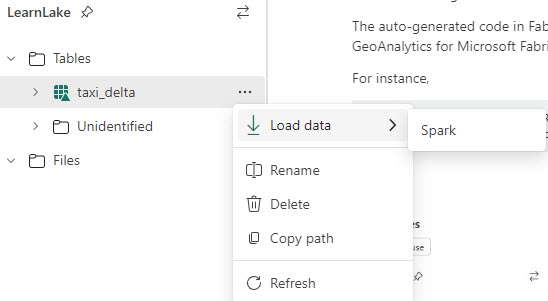

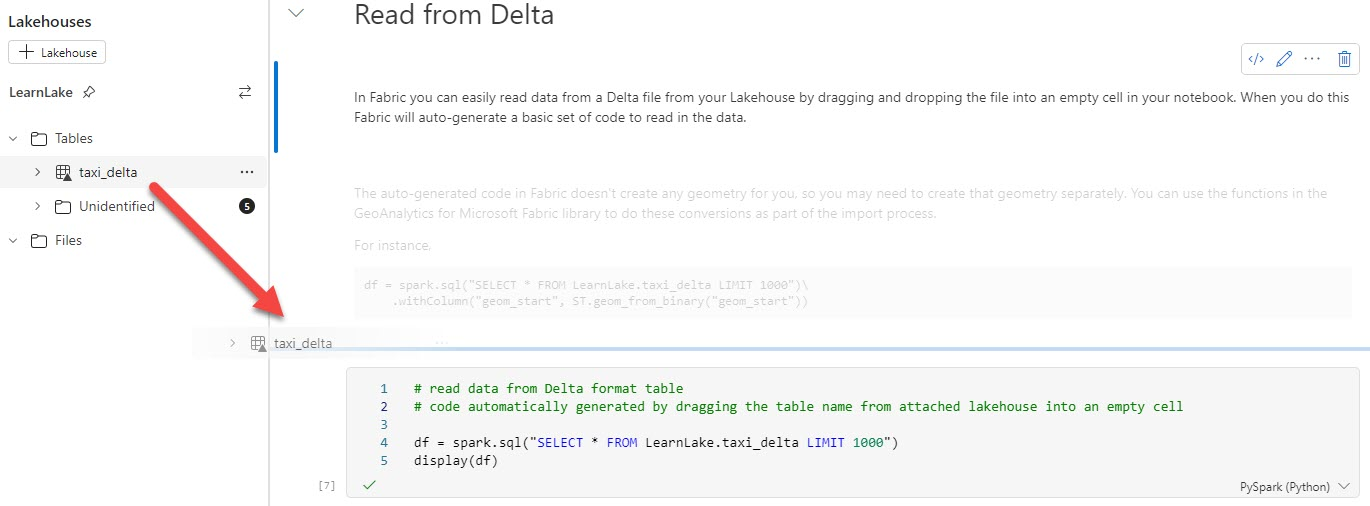

In the cell below, the code was automatically generated by Fabric to read from a Delta format table in the attached Lakehouse.  For simplicity, we have removed the specific Lakehouse name in the cell below.  

You can update the cell by deleting the contents and dragging the file from _your_ attached Lakehouse into the cell.  Fabric will create the code to read the Delta table for you and will reference the specific Lakehouse where your data is stored.

In [21]:
# read data from Delta format table 
# code was automatically generated by dragging the table name from attached lakehouse into an empty cell

df = spark.sql("SELECT * FROM taxi_delta LIMIT 1000")
display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 22, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, d2c5b178-bea0-4f88-88e9-cff893beb9f7)

When reading the well-known binary geometry in from the Delta table, you will want to convert it back to a point geometry.  If you look at the schema for the data, it will just list the `geom_start` column as `binary`.  We can update this with [ST_PointFromBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point_from_binary/).  If you don't know the geometry type, you can use the generic [ST_GeomFromBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_binary/) to create a generic geometry column.  

Converting from well-known binary to a point geometry can be done in the same code block as the initial read of the Delta table, or after the fact using PySpark [withColumn()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumn.html).

Note that if you have a generic geometry column, you can always convert it to a more specific geometry type at a later time (e.g., point, linestring, polygon) using the [ST_Cast](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_cast/) function.


In [22]:
# checking the schema shows that we have a binary type for our geom_start column
df.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 23, Finished, Available, Finished)

root
 |-- vendorID: string (nullable = true)
 |-- tpepPickupDateTime: timestamp (nullable = true)
 |-- tpepDropoffDateTime: timestamp (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- tripDistance: double (nullable = true)
 |-- puLocationId: string (nullable = true)
 |-- doLocationId: string (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- rateCodeId: integer (nullable = true)
 |-- storeAndFwdFlag: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- fareAmount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mtaTax: double (nullable = true)
 |-- improvementSurcharge: string (nullable = true)
 |-- tipAmount: double (nullable = true)
 |-- tollsAmount: double (nullable = true)
 |-- totalAmount: double (nullable = true)
 |-- puYear: integer (nullable = true)
 |-- puMonth: integer (nullable = true)
 |-- 

Use [ST_PointFromBinary](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point_from_binary/) to convert the `geom_start` column to a point geometry.

In [23]:
# convert the geom_start column from well-known binary to a point geometry.  
# Assign the spatial reference ID (SRID) of 4326 to the data, which is the WGS84 coordinate reference system
df = df.withColumn("geom_start", ST.point_from_binary("geom_start", 4326))

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 24, Finished, Available, Finished)

Taking a look at the schema again, the `geom_start` column is converted to a point geometry.

In [24]:
# checking the schema shows that we now have a point geometry for geom_start
df.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 25, Finished, Available, Finished)

root
 |-- vendorID: string (nullable = true)
 |-- tpepPickupDateTime: timestamp (nullable = true)
 |-- tpepDropoffDateTime: timestamp (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- tripDistance: double (nullable = true)
 |-- puLocationId: string (nullable = true)
 |-- doLocationId: string (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- rateCodeId: integer (nullable = true)
 |-- storeAndFwdFlag: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- fareAmount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mtaTax: double (nullable = true)
 |-- improvementSurcharge: string (nullable = true)
 |-- tipAmount: double (nullable = true)
 |-- tollsAmount: double (nullable = true)
 |-- totalAmount: double (nullable = true)
 |-- puYear: integer (nullable = true)
 |-- puMonth: integer (nullable = true)
 |-- 

You can also use the PySpark [```read```](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.SparkSession.read.html) option to read the data into a DataFrame instead of the Fabric-generated SQL code shown above.  

Both methods provide the same result in a DataFrame.

The example below reads the data and adds a column converting the geometry from a binary format into a geometry.

If you don't know the format of the data in the Delta file, you can read in the table and use PySpark [printSchema()](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.printSchema.html) or display the data in a table to examine the format of the data before converting it to a geometry.

In [25]:
# read the data from a Delta format table
# convert the well-known binary representation to a Geometry type for use with ArcGIS GeoAnalytics
# Set the coordinate system to 4326 (WGS84) when converting from well-known binary to the GeoAnalytics geometry type
df = spark.read.format("delta").load("Tables/taxi_delta")\
    .withColumn("geom_start", ST.point_from_binary("geom_start", 4326))
display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 26, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 26c7e107-362e-4584-b953-e22bfa1b49b0)

### Read from CSV (and create geometry)

In Fabric you can easily read data from a CSV file from your Lakehouse by dragging and dropping the file into an empty cell in your notebook.  When you do this Fabric will auto-generate a basic set of code to read in the data.

Just like with the Delta file, the auto-generated code in Fabric doesn't create any geometry for you, so you may need to create that geometry separately.  You can use the functions in ArcGIS GeoAnalytics to do these conversions as part of the import process.



In [26]:
# read data from CSV format table 
# code was automatically generated by dragging the table name from attached lakehouse into an empty cell

df = spark.read.format("csv").option("header","true").load("Tables/taxi_csv_wkt.csv")
# df now is a Spark DataFrame containing CSV data from "Tables/taxi_csv_wkt.csv".
display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 27, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 88e20c67-68c9-4e71-9e4b-bbb1fafa0735)

You can add a new column with the PySpark function [withColumn](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.withColumn.html) using ArcGIS GeoAnalytics [ST_GeomFromText](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_geom_from_text/) function to convert well-known text in the CSV into a geometry, or, [ST_PointFromText](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/st_point_from_text/) since we happen to know this geometry is point-based. 

If you don't know what format the geometry is in your CSV, you can display the table first to check.

In [27]:
display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 28, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, f1da0778-90a7-4e11-9141-4ee339a69ba1)

In [28]:
# convert the well-known text in the geom_start column into a geometry using ST_PointFromText
# we can define the spatial reference at the same time
df = df\
    .withColumn("geom_start", ST.point_from_text("geom_start", 4326))

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 29, Finished, Available, Finished)

The schema will now show a point geometry in the dataframe.

In [29]:
# checking the schema confirms that we have a point geometry
df.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 30, Finished, Available, Finished)

root
 |-- vendorID: string (nullable = true)
 |-- tpepPickupDateTime: string (nullable = true)
 |-- tpepDropoffDateTime: string (nullable = true)
 |-- passengerCount: string (nullable = true)
 |-- tripDistance: string (nullable = true)
 |-- puLocationId: string (nullable = true)
 |-- doLocationId: string (nullable = true)
 |-- startLon: string (nullable = true)
 |-- startLat: string (nullable = true)
 |-- endLon: string (nullable = true)
 |-- endLat: string (nullable = true)
 |-- rateCodeId: string (nullable = true)
 |-- storeAndFwdFlag: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- fareAmount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mtaTax: string (nullable = true)
 |-- improvementSurcharge: string (nullable = true)
 |-- tipAmount: string (nullable = true)
 |-- tollsAmount: string (nullable = true)
 |-- totalAmount: string (nullable = true)
 |-- puYear: string (nullable = true)
 |-- puMonth: string (nullable = true)
 |-- geom_start

The spatial reference ID can be confirmed as well with [get_spatial_reference](https://developers.arcgis.com/geoanalytics-fabric/api-reference/geoanalytics_fabric.extensions.html#get-spatial-reference).

In [30]:
# checking the spatial reference confirms the point geometry is in 4326 (the WGS84 coordinate system)
df.st.get_spatial_reference()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 31, Finished, Available, Finished)

SpatialReference(srid=4326, is_projected=False, unit='Degree', wkt='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]')

### Geoparquet

[Geoparquet](https://geoparquet.org/) is an explicitly spatial format of Apache Parquet.  If there is a valid geometry in a geoparquet file, GeoAnalytics for Microsoft Fabric can recognize that geometry automatically.  There is no additional step needed to convert the format or to redefine the spatial reference.

GeoParquet files can be read directly using the ["geoparquet" format](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geoparquet/) as implemented in ArcGIS GeoAnalytics.

In [31]:
# read a geoparquet file and display the results
df = spark.read.format("geoparquet").load("Tables/taxi_geoparquet")
display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 32, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 91e0597c-d8d1-4958-93b7-4de3a5e255ac)

Viewing the data schema confirms that the `geom_start` column was read in as a point geometry.

In [32]:
# checking the schema confirms that the point geometry is read in and no conversion is needed
df.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 33, Finished, Available, Finished)

root
 |-- vendorID: string (nullable = true)
 |-- tpepPickupDateTime: timestamp (nullable = true)
 |-- tpepDropoffDateTime: timestamp (nullable = true)
 |-- passengerCount: integer (nullable = true)
 |-- tripDistance: double (nullable = true)
 |-- puLocationId: string (nullable = true)
 |-- doLocationId: string (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- rateCodeId: integer (nullable = true)
 |-- storeAndFwdFlag: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- fareAmount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mtaTax: double (nullable = true)
 |-- improvementSurcharge: string (nullable = true)
 |-- tipAmount: double (nullable = true)
 |-- tollsAmount: double (nullable = true)
 |-- totalAmount: double (nullable = true)
 |-- puYear: integer (nullable = true)
 |-- puMonth: integer (nullable = true)
 |-- 

Checking the spatial reference also confirms that the geometry has retained the spatial reference information originally assigned.

In [33]:
# checking the spatial reference confirms the point geometry is in 4326 (the WGS84 coordinate system)
df.st.get_spatial_reference()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 34, Finished, Available, Finished)

SpatialReference(srid=4326, is_projected=False, unit='Degree', wkt='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]')

### Read from GeoJSON

GeoJSON format files can be read directly using the [geojson](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/geojson/) format as implemented in ArcGIS GeoAnalytics. If there is a valid geometry recognized, ArcGIS GeoAnalytics can recognize it automatically.  There is no additional step needed to convert the format.  

Note that the field name that was originally used for the geometry (ours was `geom_start`) will update to just be named `geometry`.



In [34]:
# read a geojson file and display the results
df = spark.read.format("geojson").load("Tables/taxi_geojson")
display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 35, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 10e91fa4-b94f-4758-961b-c9efd1a4d7d0)

Looking at the data schema shows that the original column named `geom_start` is now simply named `geometry`.  It retains the point geometry type.

In [35]:
# checking the schema confirms that the point geometry is read in and no conversion is needed
df.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 36, Finished, Available, Finished)

root
 |-- geometry: point (nullable = true)
 |-- vendorID: string (nullable = true)
 |-- tpepPickupDateTime: string (nullable = true)
 |-- tpepDropoffDateTime: string (nullable = true)
 |-- passengerCount: long (nullable = true)
 |-- tripDistance: double (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- rateCodeId: long (nullable = true)
 |-- storeAndFwdFlag: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- fareAmount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mtaTax: double (nullable = true)
 |-- improvementSurcharge: string (nullable = true)
 |-- tipAmount: double (nullable = true)
 |-- tollsAmount: double (nullable = true)
 |-- totalAmount: double (nullable = true)
 |-- puYear: long (nullable = true)
 |-- puMonth: long (nullable = true)



The spatial reference information is also retained.

In [36]:
# checking the spatial reference confirms the point geometry is in 4326 (the WGS84 coordinate system)
df.st.get_spatial_reference()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 37, Finished, Available, Finished)

SpatialReference(srid=4326, is_projected=False, unit='Degree', wkt='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]')

### Read from Shapefile
Shapefiles can be read directly using the [shapefile](https://developers.arcgis.com/geoanalytics-fabric/data/data-sources/shapefile/) format as implemented in ArcGIS GeoAnalytics. 

To read a shapefile, the folder containing the shapefile is specified, and not the full path to the *.shp file. 


In [37]:
# read a shapefile and display the results
df = spark.read.format("shapefile").load("Tables/taxi_shapefile")
display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 38, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, beb56b88-54e3-4570-8e53-79660233c54d)

Just like with the GeoJSON file, the geometry in the Shapefile is now in a column named `geometry` instead of the original `geom_start` column

The spatial reference information is also retained.

Note that with Shapefiles, there is a maximum length for column names, so some of the original column names may have been truncated.

In [38]:
# checking the schema confirms that the point geometry is read in and no conversion is needed
df.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 39, Finished, Available, Finished)

root
 |-- vendorID: string (nullable = true)
 |-- tpepPickupD: string (nullable = true)
 |-- tpepDropoff: string (nullable = true)
 |-- passengerCo: long (nullable = true)
 |-- tripDistanc: double (nullable = true)
 |-- puLocationI: string (nullable = true)
 |-- doLocationI: string (nullable = true)
 |-- startLon: double (nullable = true)
 |-- startLat: double (nullable = true)
 |-- endLon: double (nullable = true)
 |-- endLat: double (nullable = true)
 |-- rateCodeId: long (nullable = true)
 |-- storeAndFwd: string (nullable = true)
 |-- paymentType: string (nullable = true)
 |-- fareAmount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mtaTax: double (nullable = true)
 |-- improvement: string (nullable = true)
 |-- tipAmount: double (nullable = true)
 |-- tollsAmount: double (nullable = true)
 |-- totalAmount: double (nullable = true)
 |-- puYear: long (nullable = true)
 |-- puMonth: long (nullable = true)
 |-- geometry: point (nullable = true)



The spatial reference information is also retained.

In [39]:
# checking the spatial reference confirms the point geometry is in 4326 (the WGS84 coordinate system)
df.st.get_spatial_reference()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 40, Finished, Available, Finished)

SpatialReference(srid=4326, is_projected=False, unit='Degree', wkt='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]')

### Read from Feature Service
A [feature service](https://developers.arcgis.com/documentation/mapping-apis-and-services/data-hosting/services/feature-service/) is a data service that stores and hosts spatial and non-spatial data online. In a feature service, spatial datasets are feature layers and non-spatial datasets are tables. You can query, edit and analyze data in a feature service.

Feature services are not stored in OneLake, but you can access using the URL for the feature service, and any credentials needed to access the service, if it is not publicly available.

URL for a feature service layer or table hosted in ArcGIS Online: ```https://<host>/<uniqueID>/ArcGIS/rest/services/<serviceName>/FeatureServer/<Layer or Table ID>```

URL for a feature service layer or table hosted in ArcGIS Enterprise: ```https://<host>/<webadaptor>/rest/services/Hosted/<serviceName>/FeatureServer/<Layer or Table ID>```

Refer to the feature service documentation for [ArcGIS Online](https://doc.arcgis.com/en/arcgis-online/manage-data/hosted-web-layers.htm) and [ArcGIS Enterprise](https://enterprise.arcgis.com/en/server/latest/publish-services/windows/what-is-a-feature-service-.htm) for more details.



Let's look at reading from an openly available feature service hosted in Esri's [ArcGIS Living Atlas of the World](https://livingatlas.arcgis.com/en/home/).  We will access the [USA States Generalized Boundaries](https://www.arcgis.com/home/item.html?id=8c2d6d7df8fa4142b0a1211c8dd66903).

The Living Atlas of the World is the foremost collection of geographic information from around the globe. It includes maps, apps, and data layers to support your work.


 

In [40]:
# read a feature service hosted in the Living Atlas of the World
myFS="https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_States_Generalized_Boundaries/FeatureServer/0"
df = spark.read.format('feature-service').load(myFS)

display(df)

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 41, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 8f399252-1930-43b2-809a-a9768d3e4538)

Reading data from a feature service brings in both geometry and coordinate reference information.

In [41]:
# checking the schema confirms that we have a geometry column
# in this case it is specifically a "polygon" type geometry
df.printSchema()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 42, Finished, Available, Finished)

root
 |-- OBJECTID: integer (nullable = false)
 |-- STATE_ABBR: string (nullable = true)
 |-- STATE_FIPS: string (nullable = true)
 |-- STATE_NAME: string (nullable = true)
 |-- POPULATION: integer (nullable = true)
 |-- POP_SQMI: double (nullable = true)
 |-- SQMI: double (nullable = true)
 |-- Shape__Area: double (nullable = true)
 |-- Shape__Length: double (nullable = true)
 |-- shape: polygon (nullable = true)



In [42]:
# checking the spatial reference confirms the geometry is in 4326 (the WGS84 coordinate system)
df.st.get_spatial_reference()

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 43, Finished, Available, Finished)

SpatialReference(srid=4326, is_projected=False, unit='Degree', wkt='GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]')

We can also plot the data using `st.plot` to see the features on a map.

StatementMeta(, 69400198-ae48-4726-86c3-364d86c0a04a, 44, Finished, Available, Finished)

<Axes: >

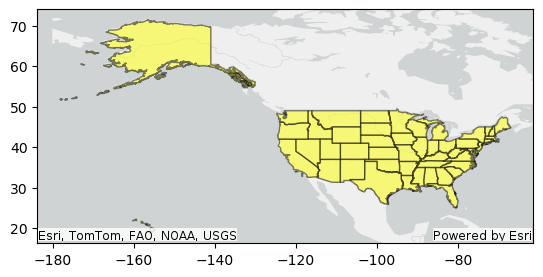

In [43]:
# plot a dataframe with geometry from a feature service
df.st.plot(basemap="light", facecolor="yellow", edgecolor="black", alpha=0.5)

When reading from feature services, if they are not publicly shared datasets you will need to explicitly specify the registered GIS that you are connecting to using `.option("gis", "myGIS")`.  More information is available on this from the documentation on [reading from Feature Services](https://developers.arcgis.com/geoanalytics-fabric/tutorials/data/read-from-feature-services/).

# Summary
In this sample notebook, you have used the ArcGIS GeoAnalytics library to read and write spatial data from a variety of data sources in your Lakehouse and as feature services.  You have also explored some of the functions in ArcGIS GeoAnalytics for creating and converting geometry features.

There are more than 180 [spatial functions](https://developers.arcgis.com/geoanalytics-fabric/sql-functions/) and [tools](https://developers.arcgis.com/geoanalytics-fabric/tools/) in ArcGIS GeoAnalytics that you can use with your spatial data sources to power complex spatial analytic workflows.  For more details on what is included in the library, check out the [developer documentation](https://developers.arcgis.com/geoanalytics-fabric/).